# Climate Change Belief Analysis
### By Team_JS_2_EDSA

<center><img src="climate-change-definition-meaning.jpg" width="90%" /></center>

# 1: Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

Twitter has become one of the most cost-effective maketing strategy platforms used by companies as way of engaging with  consumers. This notebook describes the process to classifying tweets by sentiment using Natural Language Processing techniques. It describes the initial data exploration, as well as implementation of different machine model classifiers used for predictions .

The notebook will be divided into the sections listed below.

This predict layout as follows:

    1. Introduction
    2. Import libraries and load data
    3. Data pre-processing
    4. Exploratory Data Analysis
    5. Building models
    6. Use best model on our unseen data
    7. Conclusion
    8. Submission

# 2: Import libraries and load data

Comet is a great tool for model versioning and experimentation as it records the parameters and conditions from each of the experiments- allowing for reproducing of results or going back to a previous version of the experiment.

In [1]:
from comet_ml import Experiment

In [120]:
# Run to allow Comet to log the parameters of the models and output of cells.
experiment = Experiment(api_key="amGQj1TC3Wyk9LYf7bD9xNV6G",
                        project_name="classification-predict",
                        workspace="daniel-bru",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/daniel-bru/classification-predict/3c872cad52b846d0977d9d93ef2bcb52



In [1]:
# Standard
import pandas as pd
import numpy as np
import time
import seaborn as sns
sns.set(font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline

# Natural language Processing
import re
import nltk
import spacy
import string
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier

# Performance
from sklearn.metrics import f1_score
from sklearn import metrics

# Exploratory Data Analysis
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

# Saving
import pickle
import joblib

## The data

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018!

In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes: 2, 1, 0, -1

**Class Description:**

- 2 News: the tweet links to factual news about climate change

- 1 Pro: the tweet supports the belief of man-made climate change

- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

- -1 Anti: the tweet does not believe in man-made climate change Variable definitions

**Columns:**

- sentiment: Sentiment of tweet

- message: Tweet body

- tweetid: Twitter unique id

In [2]:
#Loading data and view first few rows
pd.set_option('display.max_colwidth', None)
train = pd.read_csv("train.csv")
test = pd.read_csv("test_with_no_labels.csv")

In [3]:
train

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954
...,...,...,...
15814,1,"RT @ezlusztig: They took down the material on global warming, LGBT rights, and health care. But now they're hocking Melania's QVC. https://…",22001
15815,2,RT @washingtonpost: How climate change could be breaking up a 200-million-year-old relationship https://t.co/rPFGvb2pLq,17856
15816,0,notiven: RT: nytimesworld :What does Trump actually believe about climate change? Rick Perry joins other aides in … https://t.co/0Mp2,384248
15817,-1,RT @sara8smiles: Hey liberals the climate change crap is a hoax that ties to #Agenda2030.\nThe Climate is Being Changed byÃ¢â‚¬Â¦,819732


In [4]:
test

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928
...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about climate change. #climatechange #science #poetry #fakenews #alternativefacts https://t.co/RpUs…",895714
10542,"2016: the year climate change came home: During the hottest year on record, Karl Mathiesen travelled to Tasmania… https://t.co/WwSrJQfvMg",875167
10543,RT @loop_vanuatu: Pacific countries positive about Fiji leading the global climate change conference in November. https://t.co/PIPRndhkYd,78329
10544,"RT @xanria_00018: You’re so hot, you must be the cause for global warming. #ALDUBLaborOfLove @jophie30 @asn585",867455


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


# 3: Data pre-processing

## 3.1 - Let's do some data cleaning

Data cleaning is the process of detecting and correcting corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate, or irrelevant parts of the data. We also apply database normalization which is the process of structuring a relational database by a series of normal forms to reduce data redundancy. Applying it will also help improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints. Stemming and Lemmatization are techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

**Function below for cleaning the data**:

* Remove punctuations 
* Remove stop words
* Replace url's
* Lemmitazation 

In [6]:
def clean_tweets(message, remove_stopwords=False, eda = False, lemma=True):
    """
    A function to preprocess tweets for model training and exploratory data analysis
    :param message: String, message to be cleaned
    :param remove_stopwords: Bool, defualt is False, set to true to remove stopwords
    :param eda: Bool, defualt is False, set to true to return cleaned but readable string
    :param lemma: Bool, deafautl is True, lemmatize.
    return: String, message
    """    
    if eda == False:
        # change all words into lower case
        message = message.lower()
    
    if eda == True:
        message = re.sub('RT|rt','retweet',message)

    # replace all url-links with url-web
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    message = re.sub(url, 'web', message)
    # removing all punctuation and digits
    message = re.sub(r'[-]',' ',message)
    message = re.sub(r'[_]', ' ', message)
    message = re.sub(r'[^\w\s]','',message)
    message = re.sub('[0-9]+', '', message) 
    message = re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~âã¢¬¦¢’‘‚…]', ' ', message)
    message = re.sub("â|ã|Ã|Â", " ", message)  # removes strange character 
    message = re.sub("\\s+", " ", message)  # fills white spaces
    message = message.lstrip()  # removes whitespaces before string
    message = message.rstrip()  # removes whitespaces after string 
    
    
    if remove_stopwords == True:     
        # remove stopwords if wordcloud
        stop_words = stopwords.words('english')
        stop_words.append('web')
        stop_words.append('climate')
        stop_words.append('change')
        stop_words.append('global')
        stop_words.append('warming')
        stop_words.append('retweet')
        stop_words.append('u')
        message = ' '.join([word for word in message.split(' ') if not word in stop_words])
    
    if lemma == True:    
      # lemmatizing all words
        lemmatizer = WordNetLemmatizer()
        message = [lemmatizer.lemmatize(token) for token in message.split(" ")]
        message = [lemmatizer.lemmatize(token, "v") for token in message]
        message = " ".join(message)

    return message

In [7]:
%%time
train['message_clean']=train['message'].apply(clean_tweets)  # Cleaning of train and test message column
test['message_clean']=test['message'].apply(clean_tweets)

Wall time: 7.86 s


In [8]:
#Data after clean: Train
train.head()

,sentiment,message,tweetid,message_clean
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief doesnt think carbon dioxide be main cause of global warm and wait what web via mashable
1,1,It's not like we lack evidence of anthropogenic global warming,126103,it not like we lack evidence of anthropogenic global warm
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rt rawstory researcher say we have three year to act on climate change before it too late web web
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,todayinmaker wire wa a pivotal year in the war on climate change web
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,rt soynoviodetodas it and a racist sexist climate change deny bigot be lead in the poll electionnight


In [9]:
#Data after clean: Test
test.head()

,message,tweetid,message_clean
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760,europe will now be look to china to make sure that it be not alone in fight climate change web
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326,combine this with the poll of staffer re climate change and woman right and you have a fascist state web
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985,the scary unimpeachable evidence that climate change be already here web itstimetochange climatechange zeroco
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263,karoli morgfair osborneink dailykos putin get to you too jill trump doesnt believe in climate change at all think it s hoax
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928,rt fakewillmoore female orgasm cause global warm sarcastic republican


## 3.2 - Let's see if there is a imbalance in the data

In [10]:
#Count of data entries for different sentiments
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Class Distribution'}, xlabel='sentiment', ylabel='count'>

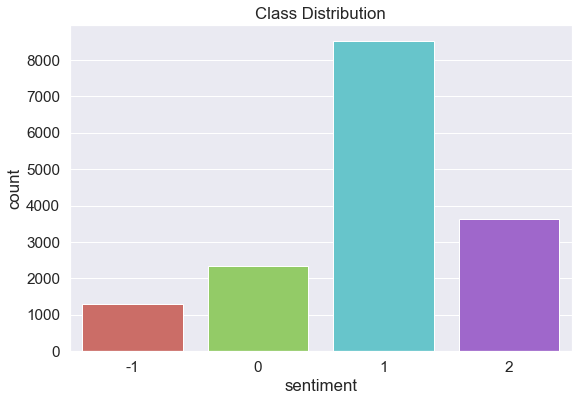

In [11]:
#View class distribution to confirm balance/imbalance
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Class Distribution')
sns.countplot(data = train, x = train['sentiment'],  palette= 'hls')

It is notable that there is an imbalance of classes in the daset  and these tend to be a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. This is can cause problems as most algorithms are designed to maximize accuracy and reduce error.

## Balancing the data

There is a different ways of balancing data:

- 1: Resampling
- 2: SMOTE

In [12]:
#Applying each sentiment to their own data frame
news = train[train['sentiment'] == 2]
pro = train[train['sentiment'] == 1]
neutral = train[train['sentiment'] == 0]
anti = train[train['sentiment'] == -1]

In [13]:
#Applying the resampling method to the data
news_upsampled = resample(news, replace=True, n_samples=len(pro), random_state=27)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(pro), random_state=27)
anti_upsampled = resample(anti, replace=True, n_samples=len(pro), random_state=27)

**Combine majority and new upsampled minority**

In [14]:
#New upsampled train dataframe
df_upsampled = pd.concat([pro, news_upsampled, neutral_upsampled, anti_upsampled])

In [15]:
df_upsampled.sentiment.value_counts()

 0    8530
 1    8530
 2    8530
-1    8530
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Class Distribution after Upsampling'}, xlabel='sentiment', ylabel='count'>

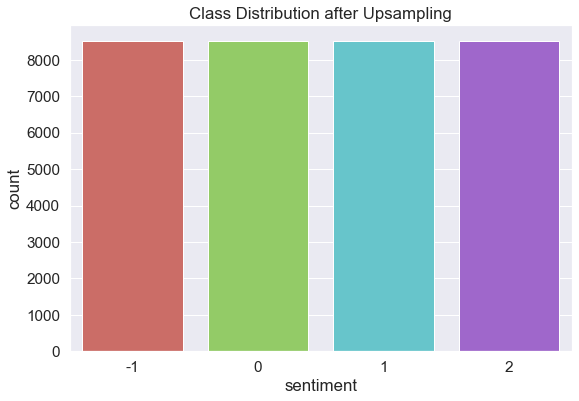

In [16]:
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Class Distribution after Upsampling')
sns.countplot(data = df_upsampled, x= df_upsampled['sentiment'], palette= 'hls')

In [17]:
df_upsampled

,sentiment,message,tweetid,message_clean
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief doesnt think carbon dioxide be main cause of global warm and wait what web via mashable
1,1,It's not like we lack evidence of anthropogenic global warming,126103,it not like we lack evidence of anthropogenic global warm
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,todayinmaker wire wa a pivotal year in the war on climate change web
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,rt soynoviodetodas it and a racist sexist climate change deny bigot be lead in the poll electionnight
5,1,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,425577,worth a read whether you do or dont believe in climate change web web
...,...,...,...,...
5422,-1,RT @worldnetdaily: Sorry global warming liars... Arctic sea ice today is about the same thickness as it was 75 years ago. https://t.co/Br60…,857394,rt worldnetdaily sorry global warm liar arctic sea ice today be about the same thickness a it wa year ago web
11148,-1,RT @charlesadler: #Trudeau gov now admitting long term climate change strategy may include burning tax $$$ to buy carbon credits. https://t…,509562,rt charlesadler trudeau gov now admit long term climate change strategy may include burn tax to buy carbon credit web
11428,-1,That would be a natural storm and of course poor government energy management driven by climate change fanatics… https://t.co/gZUwDFoR9l,158073,that would be a natural storm and of course poor government energy management drive by climate change fanatic web
1341,-1,RT @TheFoundingSon: NOAA scientists manipulated temperature data to make global warming seem worse\n\nWho's surprised? Not me\nhttps://t.co/Rj…,905959,rt thefoundingson noaa scientist manipulate temperature data to make global warm seem worse who surprise not me web


# 4: Exploratory Data Analysis

- Make use of seaborn, wordcloud and matplotlib

## 4.1: Message Length

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

Text(0, 0.5, 'Density')

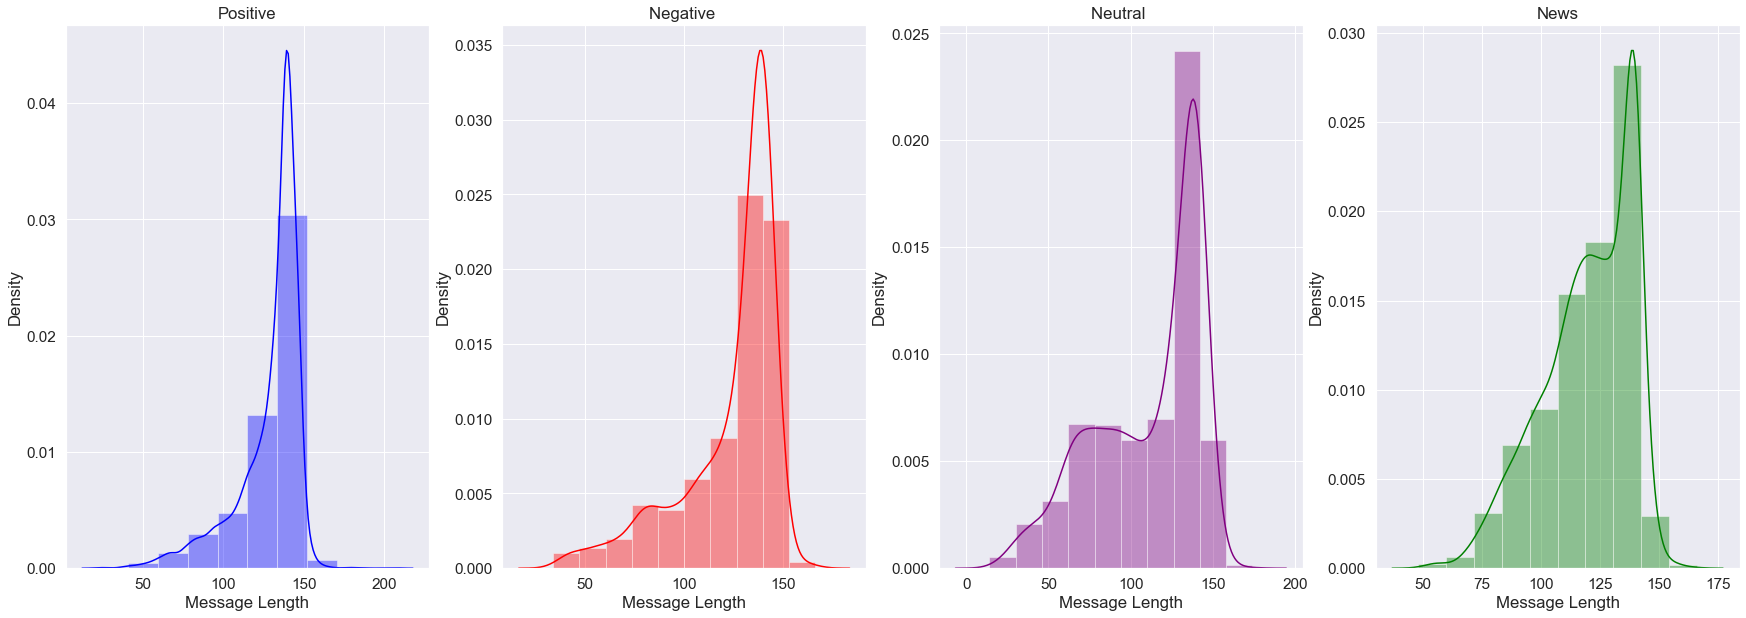

In [18]:
# Distribution plots for the different sentiments by twee message lengths
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(30,10))

#Positive 
sns.distplot(train[train['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=10, color = 'blue', 
             ax = ax1)
ax1.set_title('Positive')
ax1.set_xlabel('Message Length')
ax1.set_ylabel('Density')

#Negative 
sns.distplot(train[train['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=10, color = 'red', 
             ax = ax2)
ax2.set_title('Negative ')
ax2.set_xlabel('Message Length')
ax2.set_ylabel('Density')

#Neutral 
sns.distplot(train[train['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=10, color = 'purple',  
             ax = ax3)
ax3.set_title('Neutral ')
ax3.set_xlabel('Message Length')
ax3.set_ylabel('Density')

#News
sns.distplot(train[train['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=10, color = 'green', 
             ax = ax4)
ax4.set_title('News')
ax4.set_xlabel('Message Length')
ax4.set_ylabel('Density')

## 4.2: Extract Hashtags(#)

In [48]:
def hashtag_extract(x):
    """
    Function to extract the hashtags from the messages column
    """
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [49]:
# extracting hashtags from train tweets
anti_hashtag = hashtag_extract(train['message'][train['sentiment'] == -1])
neutral_hashtag = hashtag_extract(train['message'][train['sentiment'] == 0])
pro_hashtag = hashtag_extract(train['message'][train['sentiment'] == 1])
news_hashtag = hashtag_extract(train['message'][train['sentiment'] == 2])

# unnesting list
anti_hashtag= sum(anti_hashtag,[])
neutral_hashtag = sum(neutral_hashtag,[])
pro_hashtag = sum(pro_hashtag,[])
news_hashtag = sum(news_hashtag,[])

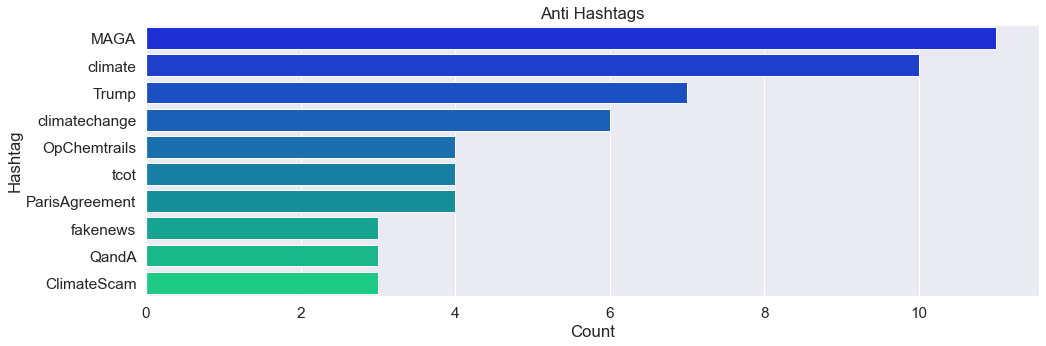

In [51]:
#creating a frequency distribution of the hashtags
v = nltk.FreqDist(anti_hashtag)
k = pd.DataFrame({'Hashtag': list(v.keys()),
                  'Count': list(v.values())})

# selecting top 10 most frequent hashtags     
k = k.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=k, x= "Count", y = "Hashtag", palette='winter')
ax.set(xlabel = 'Count', title= 'Anti Hashtags')
plt.show()

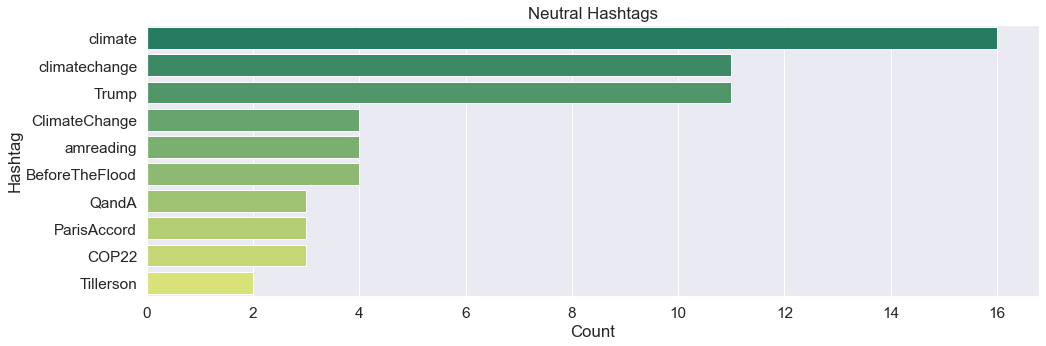

In [52]:
#creating a frequency distribution of Neutral hashtags
v = nltk.FreqDist(neutral_hashtag)
k = pd.DataFrame({'Hashtag': list(v.keys()),
                  'Count': list(v.values())})

# selecting top 10 most frequent Neutral hashtags     
k = k.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=k, x= "Count", y = "Hashtag", palette='summer')
ax.set(xlabel = 'Count', title= 'Neutral Hashtags')
plt.show()

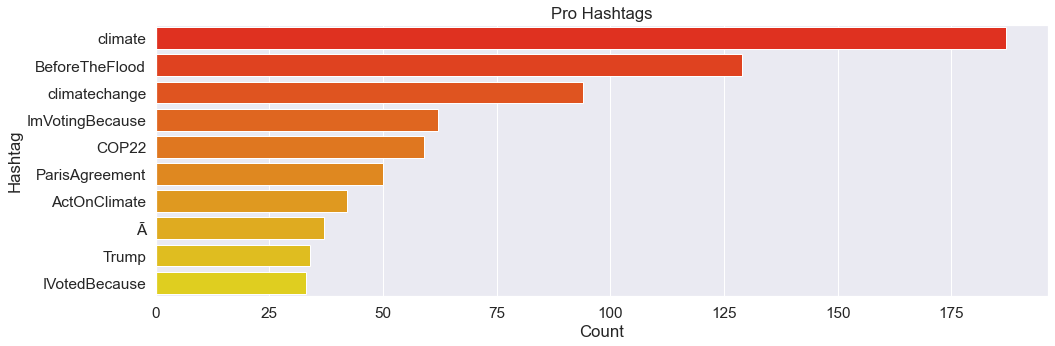

In [53]:
#creating a frequency distribution of Pro hashtags
v = nltk.FreqDist(pro_hashtag)
k = pd.DataFrame({'Hashtag': list(v.keys()),
                  'Count': list(v.values())})

# selecting top 10 most frequent Neutral hashtags     
k = k.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=k, x= "Count", y = "Hashtag", palette='autumn')
ax.set(xlabel = 'Count', title= 'Pro Hashtags')
plt.show()

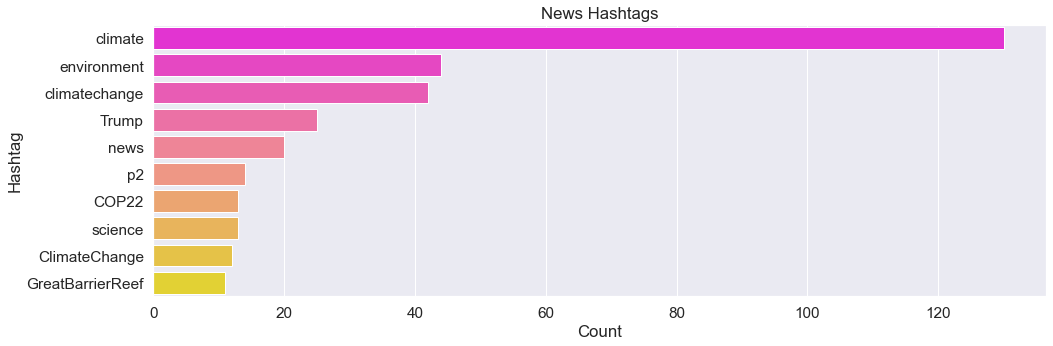

In [54]:
#creating a frequency distribution of News hashtags
v = nltk.FreqDist(news_hashtag)
k = pd.DataFrame({'Hashtag': list(v.keys()),
                  'Count': list(v.values())})

# selecting top 10 most frequent Neutral hashtags     
k = k.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=k, x= "Count", y = "Hashtag", palette='spring')
ax.set(xlabel = 'Count', title= 'News Hashtags')
plt.show()

## 4.3: Extract Frequently used words

In [56]:
# prep data for word cloud by removing stop words 
train['message_clean_eda']=train['message'].apply(lambda x: clean_tweets(message =x, remove_stopwords=True, 
                                                                         eda=True, lemma=False))

In [57]:
news_tweets = ' '.join([text for text in train['message_clean_eda']
                        [train['sentiment'] == 2]])
pro_tweets = ' '.join([text for text in train['message_clean_eda']
                       [train['sentiment'] == 1]])
neutral_tweets = ' '.join([text for text in train['message_clean_eda']
                           [train['sentiment'] == 0]])
anti_tweets = ' '.join([text for text in train['message_clean_eda']
                        [train['sentiment'] == -1]])

In [58]:
full_title = ['Popular words for News tweets',
              'Popular words for Pro tweets',
              'Popular words for Neutral tweets',
              'Popular words for Anti tweets']
tweet_list = [news_tweets, pro_tweets,neutral_tweets, anti_tweets]

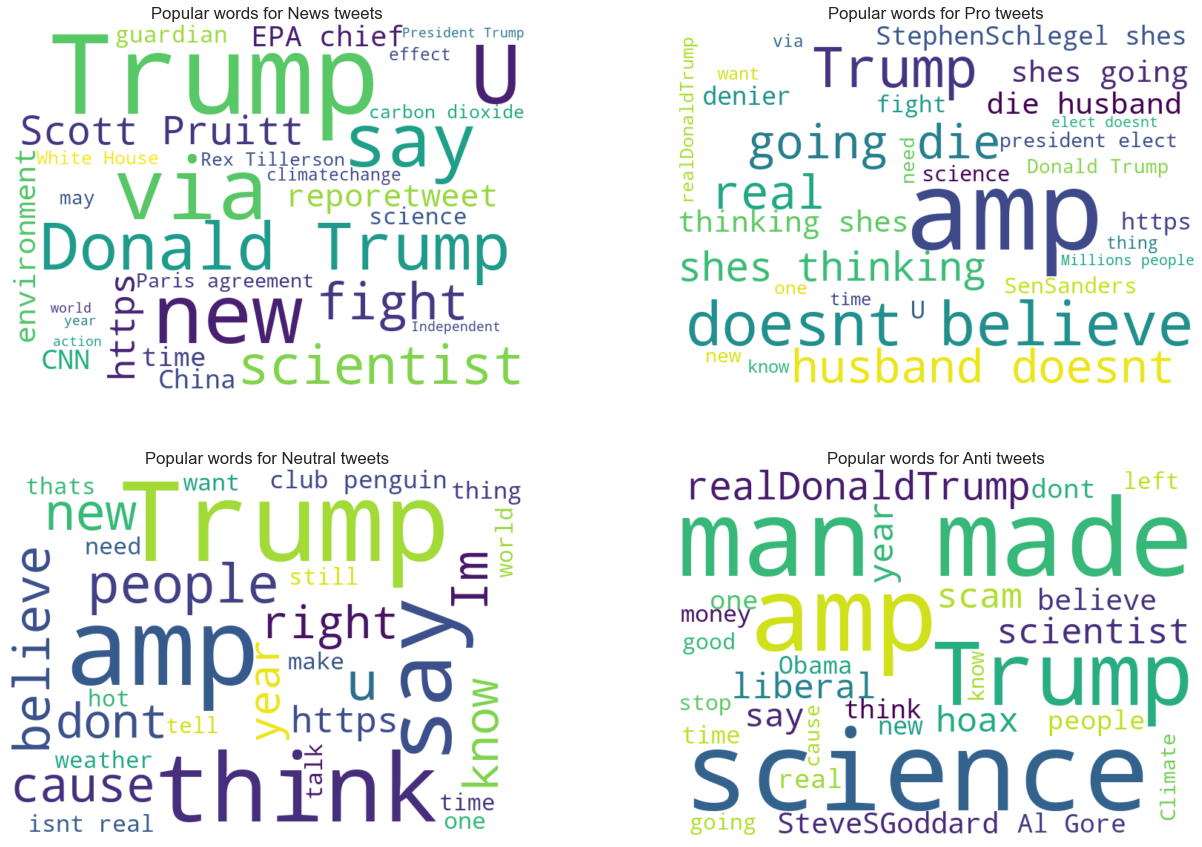

In [61]:
# Create word clouds of the 30 most common words in each sentiment class
wc = WordCloud(width=700, height=500, 
               background_color='white',
               max_words = 30,
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [22, 15]

# Create subplots 

for i in range(0, len(tweet_list)):
    wc.generate(tweet_list[i])
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(full_title[i])
    
plt.show()

## 4.4 Extracting Mentions(@)

In [32]:
# Extracting Users(@) tags in a column
train['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in train.message]

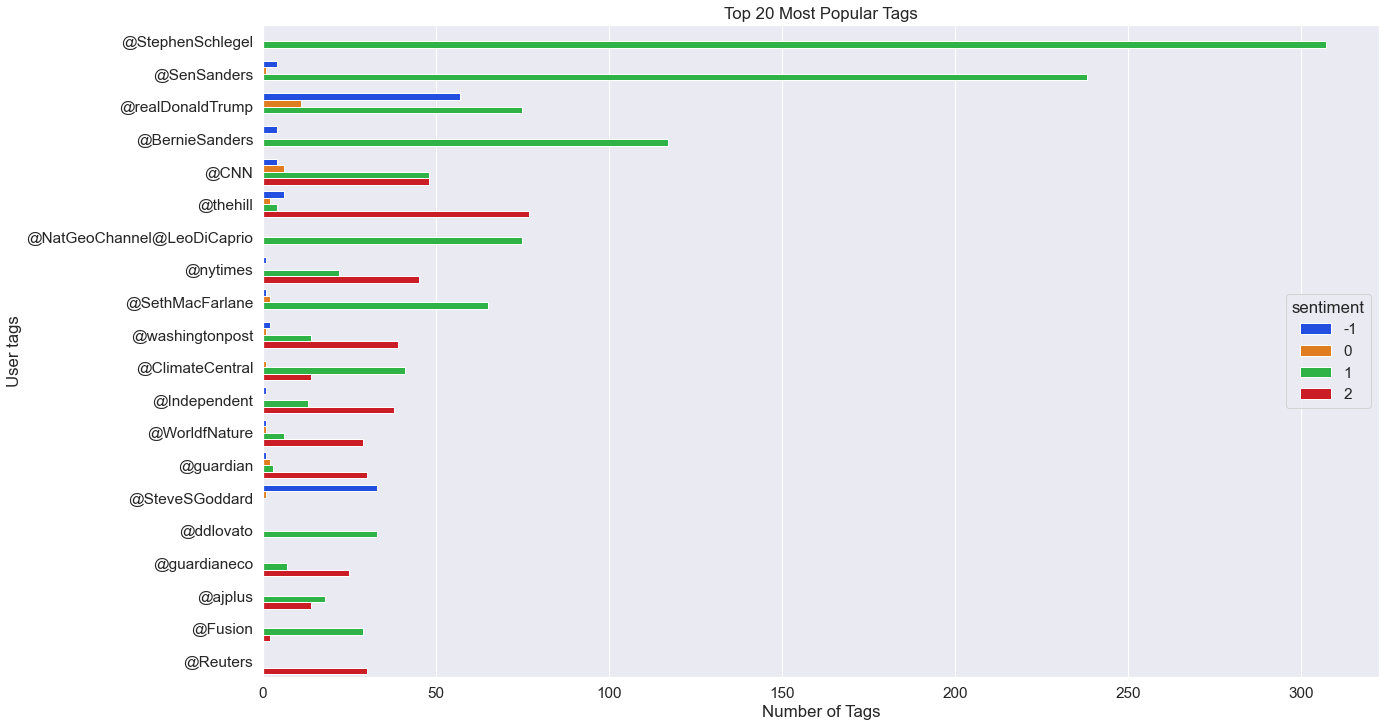

In [39]:
# Analysis of most popular tags, sorted by populariy
fig, axs = plt.subplots(figsize = (20, 12))
sns.countplot(y="users", hue="sentiment", data=train, palette='bright',
              order=train.users.value_counts().iloc[:20].index, ax=axs) 

plt.ylabel('User tags')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()

In [37]:
#The total count of messages per user tags
counts =train[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [38]:
counts.head(20)

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106
6622,@thehill,89
2521,@NatGeoChannel@LeoDiCaprio,75
5952,@nytimes,68
3296,@SethMacFarlane,68
6785,@washingtonpost,56


## Summary of above graphs:

**4.1: Messages length**
- The average length of messages for all sentiments is not surprising as a tweet is only limited to 140 characters. However, the density contrast between positive and negative sentiments is interesting.

**4.2: Messages Hashtags(#)**
- With the hashtag analyses it is clear that there are definite commonalities

*   climate
*   climatechange
*   Trump
*   COP22 (Positive, Neutral & News)

**4.3: Messages frequently used words**
- Valualble information can be gathered from these wordclouds as the words clearly display the sentiment. As an example, negative sentiment contains words like fake, hoax, scam and man made. Positive sentiment shows words like believe and real.

**4.4: Messages tags(@)**
- Most of the popular tags are pro sentimental as we also saw that most of our data is pro sentiment so it would be wise to say that the majority of users are pro climate change. A lot of well know public figures are Pro climate change.

# 5: Modeling

## The models we will be testing are:

**Linear Support Vector Classifier**
- The objective of a Linear SVC (Support Vector Classifier) is to fit to the data provided, returning a "best fit" hyperplane that divides, or categorizes, data. After getting the hyperplane,the features are fed to the classifier to see what the "predicted" class is. 

**Extra Trees Classifier**
- An extra-trees classifier is a class that implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The number of trees in the forest.

**Logistic Regression**
- Logistic regression is basically a supervised classification algorithm. In a classification problem, the target variable(or output), y, can take only discrete values for given set of features(or inputs), X.Just like Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function.

**Stochastic Gradient Descent (SGD)**
-  SGD is a simple, efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.It has received a considerable amount of attention just recently in the context of large-scale learning.

**Ada Boost Classifier**
-  It combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier. The basic concept behind Adaboost is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations.

**K-Nearest Neighbors (KNN)**
- In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method proposed by Thomas Cover used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. ... In k-NN classification, the output is a class membership.

**Multi Nomial Naive Bayes**
- In summary, Naive Bayes classifier is a general term which refers to conditional independence of each of the features in the model, while Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features

**Ridge Classifier**
- The Ridge Classifier, based on Ridge regression method, converts the label data into [-1, 1] and solves the problem with regression method. The highest value in prediction is accepted as a target class and for multiclass data muilti-output regression is applied.

**Random Forest Classifier**
- The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

## 5.1: Model Comparison

Let's train all our models with default parameters and rank them with the use of a few performance metrics which we'll generate for each model by comparing each models predicted sentiment to the actual sentintiment.


## 5.1.1: Using The Train Test Split:

Lets create a function to train and test each of our models and return a dataframe comparing each models performance metrics.

#### Performance Metrics
We'll use the F1_score with the Micro-average to compare the Accuracy of each model.

The Micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup like ours with class imbalance, micro-average is preferable over other metrics.

In [38]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [103]:
classifiers = [
               LinearSVC(random_state=42),
               ExtraTreesClassifier(),
               LogisticRegression(random_state=42, n_jobs=1, max_iter=5000),
               SGDClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               MultinomialNB(),
               RidgeClassifier(),
               RandomForestClassifier()
    ]

In [36]:
def model_assessment(classifiers, X_train , X_test , y_train , y_test):
    """
    A function to train and test different classifiers and return a performance summary. 
    :param classifiers: List of models
    :param Train Test Split
    return: Dataframe of models as index, and metrics as columns
    """  
    model_summary = {} 
    
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf', clf)
                          ])
        
        start_time = time.time()      # Logging Current Time 
        model.fit(X_train, y_train)        # Training
        predictions = model.predict(X_test)    # Testing 
        run_time = time.time() - start_time        # Calculate Execuation Time
      
    # Create Dictionary Of Each Models Performance
        model_summary[clf.__class__.__name__] = {
          'F1-Macro':metrics.f1_score(y_test, predictions, average='macro'),
          'F1-Accuracy':metrics.f1_score(y_test, predictions, average='micro'),
          'F1-Weighted':metrics.f1_score(y_test, predictions, average='weighted'),
          'Execution Time': run_time }
      
        
    return pd.DataFrame.from_dict(model_summary, orient='index') # Create/Return Dataframe

The function above is then called below and the performance summary is created and saved to a csv file. 
Therefore, **you dont need to call the function, only read in the csv file.**

In [40]:
%%time
clf_performance_df = model_assessment(classifiers, X_train , X_test , y_train , y_test)

Wall time: 2min 45s


In [43]:
clf_performance_df.to_csv('clf_performance_df.csv')

**Read the saved csv of the performance summary into a dataframe**

In [19]:
clf_performance_df = pd.read_csv('clf_performance_df.csv', index_col = 0) 

In [20]:
def graph_model_performances(df, column):
    """
    A function to graph model performances from a dataframe. 
    :param df: Dataframe
    :param column: String, column to sort by
    return: Graph
    """  
    df = df.sort_values(column, ascending=True)
    
    if column == 'F1-Weighted':
        xlim = [0.5, 0.8]
    if column == 'F1-Accuracy':
        xlim = [0.5, 0.82]
    if column == 'F1-Macro':
        xlim = [0.5, 0.75]  
    if column == 'Execution Time':
        df = df.sort_values(column, ascending=False)
        xlim = [0.6, 295]  
    if column == 'CV_Mean':
        xlim = [0.6, 0.76]
    if column == 'CV_Std':
        xlim = [0.002, 0.009]
        
    graph = df.plot(y=column, 
                    kind='barh', 
                    xlim=xlim, 
                    color= 'cyan', 
                    edgecolor = 'blue',
                    figsize=(10, 8), 
                    fontsize=16)
    return  graph

**Comparing the Models**

,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.712082,0.791403,0.778277,1.395628
ExtraTreesClassifier,0.613904,0.723135,0.704318,90.552533
LogisticRegression,0.645437,0.756005,0.736119,16.316322
SGDClassifier,0.679044,0.777497,0.759225,1.504973
AdaBoostClassifier,0.482323,0.613148,0.589334,4.774430
KNeighborsClassifier,0.607366,0.673831,0.670603,1.449638
MultinomialNB,0.388446,0.658660,0.573410,0.893303
RidgeClassifier,0.696760,0.782554,0.766927,1.220687
RandomForestClassifier,0.598813,0.697851,0.686372,47.636384


(<AxesSubplot:>, None)

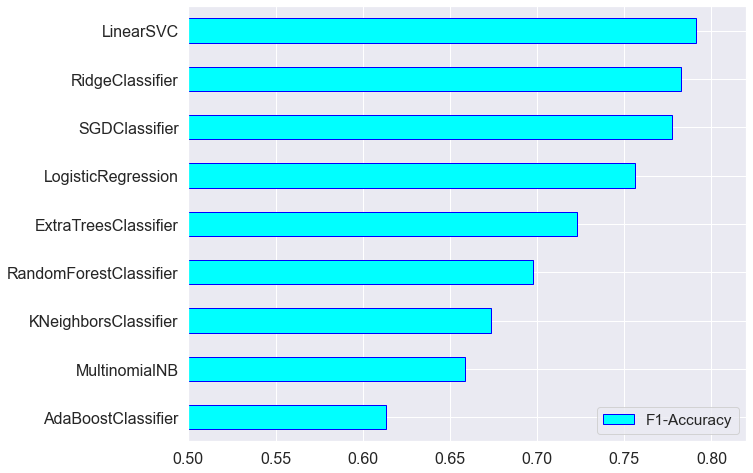

In [21]:
graph_model_performances(clf_performance_df, 'F1-Accuracy'), display(clf_performance_df)

- The LinearSVC model has the best accuracy, followed by the RidgeClassifier, then SGDClassifier.

## 5.1.2: Using Cross Validation

Let's define a function to perform 5 fold cross validation for each model and return its average score.
The mean accuracy score returned here might give us a better indication of the models predictive abilty.

In [94]:
def model_assessment_CV(X,y):
    """
    A function to perform Cross Validation on list of different classifiers and return a performance summary. 
    :param X: Feature data
    :param y: Target data
    return: Dataframe of models as index, and metrics as columns
    """    
    model_summary = [] 
    
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])

        start_time = time.time()                         # Logging Current Time 
        scores = cross_val_score(model, X=X, y=y, cv=5)     # Performing Cross Validation
        run_time = time.time() - start_time                      # Calculate Execuation Time
        model_summary.append([clf.__class__.__name__, scores.mean(), scores.std(), run_time])
    
    performace_summary = pd.DataFrame(model_summary, columns=['Model', 'CV_Mean', 'CV_Std','Execution Time'])
    performace_summary.set_index('Model', inplace=True)
 
    return performace_summary

The function above is then called below and the performance summary from cross validation is created and saved to a csv file. 
Therefore, **you dont need to call the function, only read in the csv file.**

In [28]:
%%time
CV_clf_performance_df = model_assessment_CV(X,y)

In [ ]:
ordered_CV_clf_performance_df = CV_clf_performance_df.sort_values('CV_Mean',ascending=False)
# Save the results so we dont have to run it again
ordered_CV_clf_performance_df.to_csv('ordered_CV_clf_performance_df.csv')

**Read the saved csv of the performance summary into a dataframe**

In [22]:
ordered_CV_clf_performance_df = pd.read_csv('ordered_CV_clf_performance_df.csv', index_col = 'Model')

**Comparing the Models**

,CV_Mean,CV_Std,Execution Time
Model,,,
LinearSVC,0.753904,0.007763,5.458754
RidgeClassifier,0.749985,0.008328,9.932733
SGDClassifier,0.744675,0.007363,9.578883
LogisticRegression,0.728744,0.008132,78.864897
ExtraTreesClassifier,0.722612,0.008042,280.153271
RandomForestClassifier,0.697074,0.008338,290.783042
KNeighborsClassifier,0.643783,0.005295,24.445339
MultinomialNB,0.638283,0.003658,7.435782
AdaBoostClassifier,0.630192,0.008455,34.111243


(<AxesSubplot:ylabel='Model'>, None)

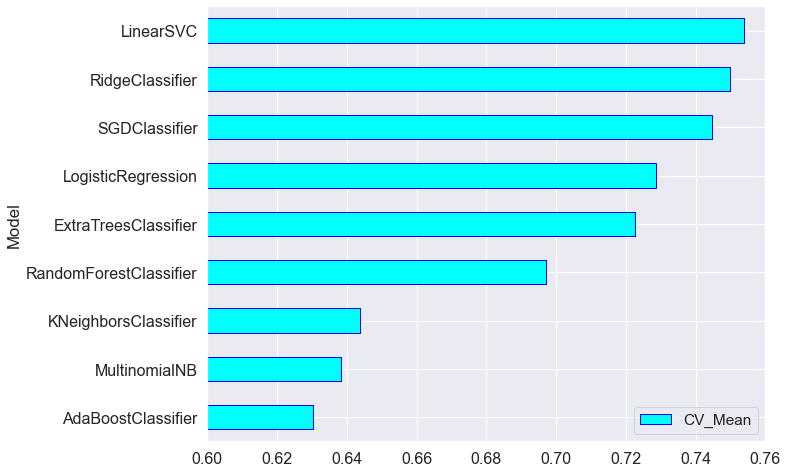

In [23]:
graph_model_performances(ordered_CV_clf_performance_df, 'CV_Mean'), display(ordered_CV_clf_performance_df)

- The shape of this performance graph looks very similar to the train test split performance.
The LinearSVC model has the best score.

## 5.2: Hyperparameter Tuning


Let's tune the hyperparameters of our 4 best models to improve their ability to classify the tweets. 

In [7]:
classifiers = [
               LinearSVC(random_state=42),
               LogisticRegression(random_state=42, n_jobs=1, max_iter=5000),
               SGDClassifier(),
               RidgeClassifier()
              ]

First, let's define a function to see what their current hyperparameters are. The function will return a dicitonary of dictionaries. The outer dictionary will have the names of the classification models as the keys. The value for each classification model key will be a dictionary of their hyperparameters. The hyperparameter dictionary will hold the hyperparameter name as key, and its value as the value.

In [17]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [27]:
def get_hyperparams(classifiers, X_train, y_train):
    """
    A function to train different classifiers and return their parameters.
    :classifiers: List of models
    return: Dictionary with model names as keys and the values are a dictionary with parameter names as keys 
            and parameter value as values.
    """  
    model_params = {}
  
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])
        
        model.fit(X_train, y_train)
        
        params = model.get_params()
        model_name = clf.__class__.__name__ 
        model_name = {}
        
        for key in params:
            if key.startswith("clf"):
                if len(key) < 5:
                    model_name['model'] = params[key]
                else:
                    model_name[key[5:]] = params[key]
        
        model_params[clf.__class__.__name__] = model_name
        
    return model_params

In [18]:
%%time
model_params = get_hyperparams(classifiers, X_train, y_train)

In [19]:
model_params[classifiers[0].__class__.__name__]  # classifiers[0] == LinearSVC

{'model': LinearSVC(random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

##  Grid Search CV

We'll use GridSearchCV to tune the hyperparamerts of our models. For each parameter we set a range of parameter values we'd like to try and create a list of them. We use all the lists to create a dictionary and pass the dictionary to the grid search function as a parameter. The grid search function will create different variants of the model, each model variant will have a different combination of parameters. 

We'll use Stratified kfold cross validation to determine what data the model variants created from the grid search is trained and tested on. We pass this to the grid search function as a parameter.

Stratified KFold is an extension of regular kfold cross validation but specifically for classification problems where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset.  

The grid search will compute each variants accuracy score and return the best hyperparameters for the model, determined from the variant with the best accuracy score.

In [121]:
# Prep the data
X = train['message_clean']
y = train['sentiment'] 

vect = TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))
X_vectorized = vect.fit_transform(X)

X_train , X_test , y_train , y_test = train_test_split(X_vectorized, y, test_size=0.05, random_state =42)

### Ridge Classifier

In [166]:
# Current Hyperparameters
model_params[classifiers[3].__class__.__name__]

{'model': RidgeClassifier(),
 'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [61]:
%%time

model = RidgeClassifier()  # define model
alpha = list(np.linspace(0.17,0.24,8)) # list of hyperparameters to loop through
class_weight = [None] 

grid = dict(alpha=alpha, class_weight=class_weight)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)  

ridge = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')

# Save parameters to comet
experiment.log_dataset_hash(X_train)      
experiment.log_parameters({"model_type": "Ridge Classifier", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 1min 46s


In [62]:
print(ridge.best_score_)
print(ridge.best_params_)      # The parameters we want
print(ridge.best_estimator_) 

0.7445604265377659
{'alpha': 0.24, 'class_weight': None}
RidgeClassifier(alpha=0.24)


### Logistic Regression

In [177]:
#Current Hyperparameters
model_params[classifiers[1].__class__.__name__]

{'model': LogisticRegression(max_iter=5000, n_jobs=1, random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
%%time
# !!! dont run this cell, takes 1hr22m to execute

# define model and parameters to loop through
model = LogisticRegression()

c_values = [150, 100, 10, 1.0, 0.5] 
penalty = ['l2']
solvers = ['lbfgs']
max_iter = [6000, 5000]

grid = dict(solver=solvers, penalty=penalty, C=c_values, max_iter=max_iter)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
logistic = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')

# Save parameters to comet
experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 1h 22min 47s


In [65]:
print(logistic.best_score_)
print(logistic.best_params_)   # The parameters we want
print(logistic.best_estimator_) 

0.7445436868541936
{'C': 100, 'max_iter': 6000, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=100, max_iter=6000)


In [67]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.78      0.46      0.58        61
           0       0.69      0.39      0.50       123
           1       0.78      0.91      0.84       441
           2       0.82      0.83      0.82       166

    accuracy                           0.78       791
   macro avg       0.76      0.65      0.68       791
weighted avg       0.77      0.78      0.76       791

0.7619583543886658


### Stochastic Gradient Descent Classifier

In [185]:
# Current Hyperparameters
model_params[classifiers[2].__class__.__name__]

{'model': SGDClassifier(),
 'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [88]:
%%time
# define model and parameters to loop through
model = SGDClassifier()
alpha = [0.00002, 0.000015, 0.000017, 0.000018]
power_t = [0.32, 0.3, 0.28]
penalty = ['l2']
max_iter = [6000]

# define grid search
grid = dict(penalty=penalty, alpha=alpha, max_iter=max_iter, power_t=power_t)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
sgd = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')

# Save parameters to comet
experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 39.7 s


In [89]:
print(sgd.best_score_)
print(sgd.best_params_)      # The parameters we want
print(sgd.best_estimator_) 

0.7472554292373719
{'alpha': 2e-05, 'max_iter': 6000, 'penalty': 'l2', 'power_t': 0.32}
SGDClassifier(alpha=2e-05, max_iter=6000, power_t=0.32)


In [90]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.75      0.49      0.59        61
           0       0.66      0.41      0.51       123
           1       0.79      0.90      0.84       441
           2       0.81      0.86      0.83       166

    accuracy                           0.78       791
   macro avg       0.75      0.66      0.69       791
weighted avg       0.77      0.78      0.77       791

0.7696406834673507


### Linear SVC 

In [186]:
#Current Hyperparameters
model_params[classifiers[0].__class__.__name__]

{'model': LinearSVC(random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [115]:
%%time
# define model and parameters to loop through
model = LinearSVC()
C = [1, 1.3]
max_iter = [1000]
class_weight = ['balanced', None]

grid = dict(C=C, max_iter=max_iter, class_weight=class_weight)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
lsvc = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')

# Save parameters to comet
experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 51 s


In [116]:
print(lsvc.best_score_)
print(lsvc.best_params_)     # The parameters we want
print(lsvc.best_estimator_) 

0.7511315295394302
{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
LinearSVC(C=1, class_weight='balanced')


In [117]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.72      0.56      0.63        61
           0       0.64      0.47      0.54       123
           1       0.82      0.86      0.84       441
           2       0.78      0.87      0.82       166

    accuracy                           0.78       791
   macro avg       0.74      0.69      0.71       791
weighted avg       0.77      0.78      0.77       791

0.7724148569820287


In [119]:
experiment.end() 

We've found the best hyperparamers for each model from calling  model.best_params_  after the grid search and now we can continue our assessment of each models performance.

## 5.3: Model Assessment

Let's train our models again with their tuned hyperparameters as parameters and assess their accuracy from a train test split and cross validation.

In [ ]:
X = train['message_clean']
y = train['sentiment'] 
X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

**Our Models**

In [132]:
best_classifiers = [ 
                     LinearSVC(C = 1, max_iter= 1000),
                     LogisticRegression(C= 100, max_iter= 6000, penalty= 'l2', solver= 'lbfgs', n_jobs=1),
                     SGDClassifier(alpha=2e-05, max_iter= 6000, penalty='l2', power_t= 0.32),
                     RidgeClassifier(alpha=0.24)
                   ]

We now call the preddefined model assessment functions below and the performance summary is created and saved to a csv file. 
Therefore, **you don't need to call the functions, only read in the csv files in the next section.**

In [133]:
%%time
best_performing_df = model_assessment(best_classifiers, X_train , X_test , y_train , y_test)
best_performing_df.to_csv('best_performing_df.csv') 

Wall time: 53 s


In [ ]:
%%time      
CV_best_performing_df = model_assessment_CV(X,y, best_classifiers) # this function took 5 min to execute
CV_best_performing_df.to_csv('CV_best_performing_df.csv')

 ## 5.3.1: Visualising the Improvement

Let's create a function to help us visualise how each model has improved. 

In [25]:
def graph_model_improvement(tuned_models_performance, models_performance, column):
    """
    A function to visualise model improvements after hyperparameter tuning 
    :param tuned_models_performance: Dataframe of model performances after tuning
    :param models_performance:       Dataframe of model performances beofre tuning
    :column:                         String, column to sort by
    return: Graph
    """  
    after = tuned_models_performance.sort_values(column,ascending=True)
    before = models_performance.sort_values(column,ascending=True)
    
    if column == 'Execution Time':
        xlim = [0.9, 50]
        after = tuned_models_performance.sort_values(column,ascending=False)
        before = models_performance.sort_values(column,ascending=False)
    else:
        xlim = [0.5, 0.8]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(xlim)
    plt.rcParams['font.size'] = '12'

    models_after_tuning = after[column].index
    metrics_after = after[column]
    metrics_before = before[column][models_after_tuning]

    after_tuning = ax.barh(y= models_after_tuning, width= metrics_after, height =0.3, color= 'blue', 
                                   edgecolor = 'red',label = 'AFTER TUNING')
    before_tuning = ax.barh(y=models_after_tuning, width= metrics_before, height =0.3, color= 'cyan', 
                        edgecolor = 'red', label = 'BEFORE TUNING')
    ax.set_title(column)

    ax.legend()
    return plt.show()

### Train Test Split Assessment

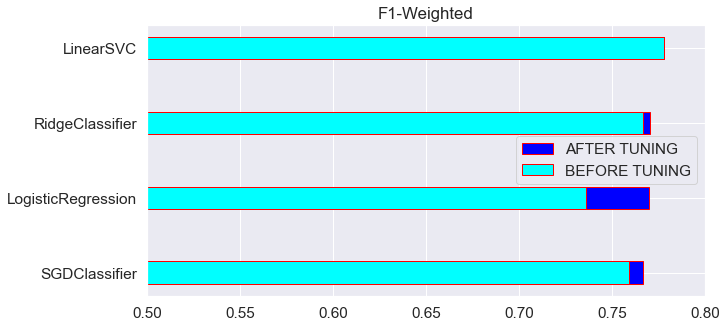

After Tuning: 


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.712082,0.791403,0.778277,1.337704
RidgeClassifier,0.705918,0.783818,0.770753,1.712695
LogisticRegression,0.703836,0.781290,0.769918,48.729028
SGDClassifier,0.698435,0.778761,0.766704,1.144923


Before Tuning: 


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.712082,0.791403,0.778277,1.395628
RidgeClassifier,0.696760,0.782554,0.766927,1.220687
SGDClassifier,0.679044,0.777497,0.759225,1.504973
LogisticRegression,0.645437,0.756005,0.736119,16.316322


In [167]:
clf_performance_df = pd.read_csv('clf_performance_df.csv', index_col = 0) 
best_performing_df = pd.read_csv('best_performing_df.csv', index_col = 0) 

ordered_best_performing_df = best_performing_df.sort_values('F1-Accuracy',ascending=False)
ordered_clf_performance_df = clf_performance_df.sort_values('F1-Accuracy',ascending=False)


graph_model_improvement(best_performing_df, clf_performance_df, 'F1-Weighted')
print('After Tuning: ')
display(ordered_best_performing_df)
print('Before Tuning: ')
display(ordered_clf_performance_df.iloc[0:4])

- The LinearSVC performs best with its default parameters
- The Logistic Regression model sees the biggest improvement throughout the metrics. We also have to note that its         excection time has trippled. 
- The RidgeClasifier holds its place at second with slight improvement.

### Cross Validation Assessment

The mean accuracy score returned here might give us a better indication of the models newfound predictive abilty.

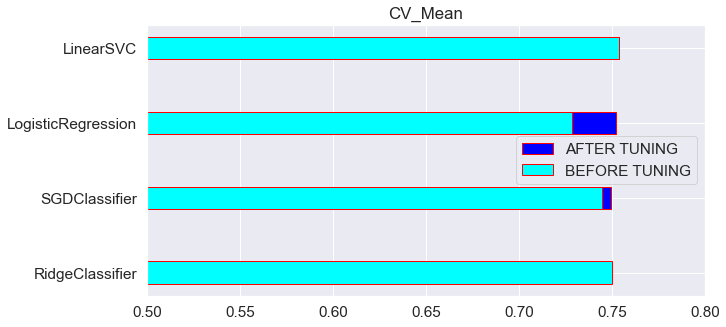

After Tuning: 


,CV_Mean,CV_Std,Execution Time
Model,,,
LinearSVC,0.753904,0.007175,5.393523
LogisticRegression,0.752134,0.010666,215.693968
SGDClassifier,0.749352,0.007394,4.698813
RidgeClassifier,0.748215,0.008174,7.626865


Before Tuning: 


,CV_Mean,CV_Std,Execution Time
Model,,,
LinearSVC,0.753904,0.007763,5.458754
RidgeClassifier,0.749985,0.008328,9.932733
SGDClassifier,0.744675,0.007363,9.578883
LogisticRegression,0.728744,0.008132,78.864897


In [26]:
ordered_CV_clf_performance_df = pd.read_csv('ordered_CV_clf_performance_df.csv', index_col = 'Model')
CV_best_performing_df = pd.read_csv('CV_best_performing_df.csv', index_col = 'Model') 

ordered_CV_best_performing_df = CV_best_performing_df.sort_values('CV_Mean',ascending=False)

graph_model_improvement(CV_best_performing_df, ordered_CV_clf_performance_df, 'CV_Mean')
print('After Tuning: ')
display(ordered_CV_best_performing_df)
print('Before Tuning: ')
display(ordered_CV_clf_performance_df.iloc[0:4])

- LinearSVC is the best with its default parameters.  
- LogisticRegression comes at a very very close second but it's training time is 40x more than the LinearSVC.
    It aslo showed the most impovement after tuning it's hyperparameters.

## 5.4: Best Model

In [200]:
X = train['message_clean']
y = train['sentiment']

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [201]:
%%time

model = LinearSVC()

#Pipeline for training
model_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))), 
                        ('classification', model) 
                        ])

#Fitting our Linear SVC model
model_pipe.fit(X_train, y_train) 


Wall time: 1.4 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classification', LinearSVC())])

### After fitting our model now we predict and evaluate our model

In [202]:
y_pred = model_pipe.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.77      0.56      0.65        61
           0       0.72      0.41      0.52       123
           1       0.80      0.90      0.85       441
           2       0.79      0.88      0.83       166

    accuracy                           0.79       791
   macro avg       0.77      0.69      0.71       791
weighted avg       0.79      0.79      0.78       791

f1 score:  0.7782768884878878


### As we can see our model predicts very accurate on our train test and split data with a 79% accuracy, now we will go and use the model on our unseen test data

# 6: Use best model on our test/real word data

## Save the Model

In [207]:
X = train['message_clean']
y = train['sentiment'] 

vect = TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))
X_vect = vect.fit_transform(X)

model = LinearSVC()

model.fit(X_vect, y) # now we train the model with entire dataset as we've done validation

# Pickle the model
model_save_path = "resources/LinearSVC.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)
# Pickle the vect
vect_save_path = "resources/tfidfvect.pkl"
with open(vect_save_path,'wb') as file:
    pickle.dump(vect,file)
print('Saved.')

Saved.


## Prediction time

In [208]:
X = test['message_clean']

# Unpickle, predict

model_load_path = "resources/LinearSVC.pkl"
with open(model_load_path,'rb') as file:
    model = pickle.load(file)

vect_load_path = "resources/tfidfvect.pkl"
with open(vect_load_path,'rb') as file:
    vect = joblib.load(file)

X_vect = vect.transform(X)

# Predict
test['sentiment'] = model.predict(X_vect)

In [209]:
# Viewing our test data with predicted sentiment
test.head()

,message,tweetid,message_clean,sentiment
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760,europe will now be look to china to make sure that it be not alone in fight climate change web,1
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326,combine this with the poll of staffer re climate change and woman right and you have a fascist state web,1
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985,the scary unimpeachable evidence that climate change be already here web itstimetochange climatechange zeroco,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263,karoli morgfair osborneink dailykos putin get to you too jill trump doesnt believe in climate change at all think it s hoax,1
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928,rt fakewillmoore female orgasm cause global warm sarcastic republican,0


# 7: Conclusion

We used 9 different models to predict our sentiment analysis. Four of these models have an F1-Macro score that is higher than 0.7. The dataset was quite unbalanced in this may lead to a score not much higher than 0.7.

The LinearSVC model is still the best model overall but after some hyperparameter tuning we managed to get a better prediction score with logistic regression. Both models managed to give us a F1-accuracy score of 79%.

Our model predicted the news and pro categories the best, while the other categories did improve. Although only more accurate by a couple of percent. So overall the model performed as anticipated.Based on the findings it can be concluded that more customers will be receptive to eco-friendly products and services provided by companies. The results prove that more people believe that climate change is a threat to our lives and that it is up to us to reduce our carbon footprint.

There are possibilities of obtaining better results using other parameter tuning and better-preprocessing techniques. We commit to continue researching discovering and training models that would yield optimal results. 

The insights gained from the EDA as well as model evaluation will be useful in providing stakeholders that are interested in climate change and related policies understand the distribution of sentiments around the issue.

# 8: Submission


In [210]:
# Submission in kaggle format
submission = test[['tweetid', 'sentiment']]
submission.to_csv('LinearSVC.csv',index=False)